## Notebook for Running Experiments on CovType Data Set

In [1]:
from typing import List
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import scipy
import pickle
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from labellines import labelLines
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

import nannyml as nml
from test_harness.datasets.dataset import Dataset

from urllib.request import urlopen
from sklearn.preprocessing import LabelEncoder

In [3]:
from  test_harness.experiments.dde_experiment import DDEffectExperiment
from test_harness.experiments.baseline_experiment import BaselineExperiment

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Load Data

#### Heartbeats dataset

1000 train originally

In [5]:
full_df = pd.read_csv("../data/heartbeats_full.data", header=None)#.rename(columns={'period': 'period_original'})
full_df.columns = [f'feat_{c+1}' for c in full_df.columns]
full_df = full_df.rename(columns={full_df.columns[-1]: 'class'})

In [6]:
full_df

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_272,feat_273,feat_274,feat_275,feat_276,feat_277,feat_278,feat_279,feat_280,class
0,-0.583660,-1.19050,-1.06650,-1.00280,-0.96759,-1.09060,-1.43060,-1.50040,-1.81840,-1.037700,...,-2.768900,-2.443700,-2.499100,-2.534600,-2.519600,-2.257900,-2.266700,-2.138000,-2.394400,8
1,-0.472420,-0.49045,-0.50777,-0.52436,-0.54024,-0.55541,-0.56987,-0.58362,-0.59666,-0.609010,...,2.617000,2.650600,2.683700,2.716100,2.748000,2.779200,2.809900,2.839800,2.869200,8
2,-0.841230,-0.99355,-0.60240,-0.88060,-0.83972,-0.89159,-1.20550,-1.20930,-0.82451,-0.082188,...,-0.292010,-0.299460,-0.300060,-0.228640,-0.308050,-0.221880,-0.129280,-0.457620,0.218760,1
3,-0.784450,-0.91108,-0.63747,-0.80738,-0.78744,-0.87697,-1.10290,-1.11380,-0.77736,0.009708,...,-0.100310,-0.091361,-0.107160,-0.053507,-0.094967,-0.074152,-0.001559,-0.184430,0.164560,1
4,-0.803560,-0.88539,-0.76955,-1.01080,-1.21240,-1.30290,-0.94300,-0.07803,0.71332,1.142900,...,-0.305020,-0.303850,-0.308990,-0.284710,-0.312510,-0.288680,-0.244850,-0.360740,-0.180830,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77899,0.631060,0.74096,0.84225,1.13200,1.44300,1.93090,2.58450,3.30950,4.09030,4.752300,...,0.070819,0.068431,0.061483,0.064957,0.072900,0.090139,0.097796,0.119520,0.161570,3
77900,0.059665,0.16575,0.35738,0.62163,0.99412,1.53410,2.19410,2.94730,3.71320,4.246600,...,0.572050,0.573180,0.553140,0.594890,0.577380,0.640070,0.583920,0.701510,0.678370,3
77901,0.478810,0.67104,0.83665,1.22040,1.58990,2.20450,2.96800,3.74530,4.45670,4.953200,...,-0.035709,-0.046083,-0.042969,-0.028890,-0.036115,0.004972,-0.021184,0.047317,0.057406,3
77902,0.584420,0.71022,0.90344,1.19610,1.62550,2.19560,2.82180,3.61170,4.29180,4.760900,...,0.125240,0.135670,0.131170,0.136890,0.141620,0.143550,0.162590,0.187010,0.249300,3


<AxesSubplot:>

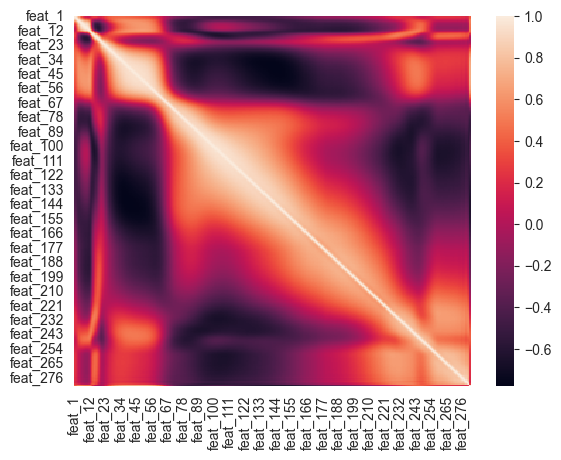

In [7]:
sns.heatmap(full_df.corr())

In [13]:
full_df['class'] = np.where(~full_df['class'].isin([1, 3]), 2, full_df['class'])

In [14]:
cat_features = []

In [15]:
numeric_features = full_df.columns

In [16]:
# model_cicids = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
# param_grid = {"clf__n_estimators": [5], "clf__max_depth": [5]}

              precision    recall  f1-score   support

           1       0.88      0.94      0.91      5842
           2       0.77      0.66      0.71      1579
           3       1.00      0.99      0.99     54903

    accuracy                           0.98     62324
   macro avg       0.88      0.86      0.87     62324
weighted avg       0.98      0.98      0.98     62324

Accuracy: 0.978483409280534


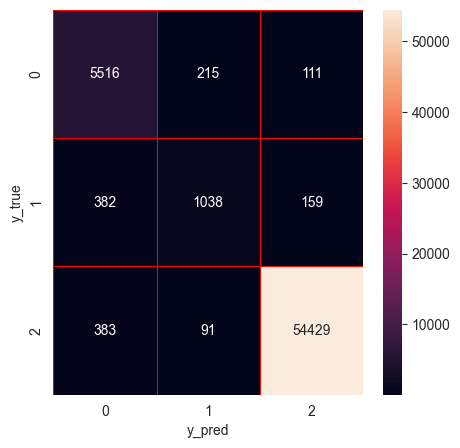

In [17]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

X = full_df.drop(['class'],axis=1)
y = full_df['class']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.2, test_size = 0.8, shuffle=False, random_state = 0)

# # LightGBM algorithm
import lightgbm as lgb
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: "+ str(accuracy_score(y_test, y_pred)))

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [18]:
top_feats_df = pd.DataFrame({'Value':model.feature_importances_,'Feature':X_train.columns.tolist()}).sort_values(by="Value",ascending=False)

In [19]:
top_feats_df

,Value,Feature
0,256,feat_1
7,220,feat_8
11,208,feat_12
3,187,feat_4
34,184,feat_35
...,...,...
220,3,feat_221
270,2,feat_271
233,2,feat_234
266,1,feat_267


In [20]:
top_feats = top_feats_df.Feature.tolist() #top_feats = top_feats_df.Feature.tolist() #

In [21]:
full_df_reduced = full_df[top_feats]

In [22]:
column_mapping_adult = {
    "target": "class",
    "numerical_features": full_df_reduced.columns,
    "categorical_features": [],
}

In [45]:
CT_dataset = Dataset(
    full_df=full_df_reduced, column_mapping=column_mapping_adult, window_size=1500 * 2, reference_size=10000
)

In [46]:
CT_dataset.full_df

,feat_1,feat_8,feat_12,feat_4,feat_35,feat_7,feat_3,feat_9,feat_6,feat_14,...,feat_162,feat_111,feat_177,feat_220,feat_193,feat_221,feat_271,feat_234,feat_267,feat_265
0,-0.583660,-1.50040,-2.26940,-1.00280,2.187800,-1.43060,-1.06650,-1.81840,-1.09060,-0.48698,...,-0.186500,-0.50846,-0.120510,0.318080,-0.058840,0.340520,-2.790100,0.59253,-1.745000,-0.549050
1,-0.472420,-0.58362,-0.63163,-0.52436,-0.715300,-0.56987,-0.50777,-0.59666,-0.55541,-0.65154,...,-0.660020,-0.43585,-0.567920,0.515840,-0.307640,0.553980,2.582800,1.08100,2.440600,2.366600
2,-0.841230,-1.20930,1.15110,-0.88060,-2.404800,-1.20550,-0.60240,-0.82451,-0.89159,1.17680,...,0.599620,0.91527,0.209910,-0.028353,0.208350,-0.048506,-0.307660,-0.12657,-0.324280,-0.318010
3,-0.784450,-1.11380,1.22910,-0.80738,-2.397200,-1.10290,-0.63747,-0.77736,-0.87697,1.11500,...,0.337730,1.31660,0.138440,-0.049039,0.061417,-0.043437,-0.131310,-0.10837,-0.141290,-0.152260
4,-0.803560,-0.07803,1.09970,-1.01080,-2.610900,-0.94300,-0.76955,0.71332,-1.30290,0.74887,...,0.540900,1.01900,0.352300,-0.094090,0.207270,-0.102120,-0.322080,-0.31246,-0.351330,-0.370570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77899,0.631060,3.30950,5.51970,1.13200,0.022763,2.58450,0.84225,4.09030,1.93090,5.58540,...,-0.056359,-0.70172,0.073093,-0.100380,-0.133390,-0.100790,0.071126,0.24684,-0.000687,-0.014166
77900,0.059665,2.94730,4.93620,0.62163,-0.488030,2.19410,0.35738,3.71320,1.53410,4.93720,...,0.044834,-0.87522,0.510970,0.292950,0.184410,0.310290,0.551000,0.77740,0.496760,0.485010
77901,0.478810,3.74530,5.60520,1.22040,-0.098540,2.96800,0.83665,4.45670,2.20450,5.18660,...,0.106500,-0.83170,0.330250,-0.003600,0.052953,-0.000416,-0.042624,0.33703,-0.072743,-0.065890
77902,0.584420,3.61170,5.37250,1.19610,-0.173430,2.82180,0.90344,4.29180,2.19560,5.18930,...,-0.069449,-0.91804,0.349610,0.152300,-0.076125,0.188720,0.114550,0.57379,0.060130,0.048681


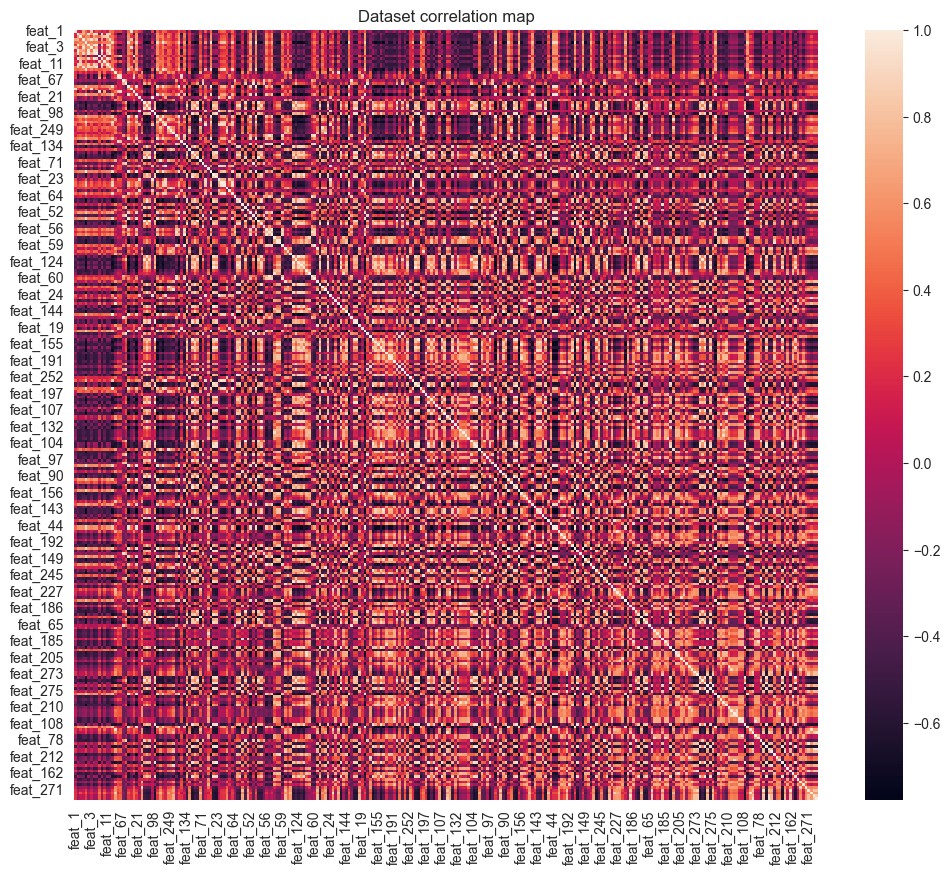

In [47]:
plt.figure(figsize=(12,10))
sns.heatmap(CT_dataset.full_df.corr(), annot=False)

plt.title('Dataset correlation map')
plt.show()

## Run Experiments

In [48]:
def windowed_correlation(df, mode='expanding'):
    corr_dict = {}
    columns = df.columns
    n = len(columns)
    for i in range(n):
        for j in range(i+1, n):
            col1 = columns[i]
            col2 = columns[j]
            key = (col1, col2)

            if mode=='expanding':
                corr_dict[key] = df[col1].expanding(10).corr(df[col2])
            else:
                corr_dict[key] = df[col1].rolling(window=10).corr(df[col2])

            corr_dict[key] = corr_dict[key].fillna(0)

    return corr_dict

In [49]:
def plot_windowed_correlation(corr_dict, vertical_lines=None):
    plt.figure(figsize=(15,10))
    for (col1, col2), corr in corr_dict.items():
        plt.plot(corr, label=f"{col1} vs {col2}")

    if vertical_lines:
        [plt.axvline(x, color='gray', linestyle='--') for x in vertical_lines if x != 0]

    plt.legend(bbox_to_anchor=(1, 0.5))
    labelLines(plt.gca().get_lines(), align=True)
    plt.show()

In [50]:
#corr_dict = windowed_correlation(CT_dataset.full_df.loc[:, CT_dataset.full_df.columns], mode='expanding')

In [51]:
#plot_windowed_correlation(corr_dict)

In [52]:
column_names = list(CT_dataset.reference_df.columns)

In [53]:
len(column_names)

282

In [78]:
calc = nml.UnivariateDriftCalculator(
    column_names=column_names,
    #timestamp_column_name='sample_num',
    continuous_methods=['jensen_shannon'],
    categorical_methods=['jensen_shannon'],
    #chunk_number=10,
    chunk_size=2000,
)

calc.fit(CT_dataset.reference_df)

In [79]:
results = calc.calculate(CT_dataset.analysis_df)

In [80]:
results_js = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).to_df()
results_js.columns = ['_'.join(col) for col in results_js.columns.values]

In [81]:
display(results_js.iloc[18:21])

,chunk_chunk_key,chunk_chunk_chunk_index,chunk_chunk_start_index,chunk_chunk_end_index,chunk_chunk_start_date,chunk_chunk_end_date,chunk_chunk_period,feat_1_jensen_shannon_value,feat_1_jensen_shannon_upper_threshold,feat_1_jensen_shannon_lower_threshold,...,feat_267_jensen_shannon_lower_threshold,feat_267_jensen_shannon_alert,feat_265_jensen_shannon_value,feat_265_jensen_shannon_upper_threshold,feat_265_jensen_shannon_lower_threshold,feat_265_jensen_shannon_alert,sample_num_jensen_shannon_value,sample_num_jensen_shannon_upper_threshold,sample_num_jensen_shannon_lower_threshold,sample_num_jensen_shannon_alert
18,[36000:37999],18,36000,37999,None,None,analysis,0.251868,0.1,None,...,None,True,0.296797,0.1,None,True,1.0,0.1,None,True
19,[38000:39999],19,38000,39999,None,None,analysis,0.280487,0.1,None,...,None,True,0.308638,0.1,None,True,1.0,0.1,None,True
20,[40000:41999],20,40000,41999,None,None,analysis,0.325952,0.1,None,...,None,True,0.362072,0.1,None,True,1.0,0.1,None,True


In [82]:
results_js[[col for col in results_js.columns if '_jensen_shannon_value' in col]]

,feat_1_jensen_shannon_value,feat_8_jensen_shannon_value,feat_12_jensen_shannon_value,feat_4_jensen_shannon_value,feat_35_jensen_shannon_value,feat_7_jensen_shannon_value,feat_3_jensen_shannon_value,feat_9_jensen_shannon_value,feat_6_jensen_shannon_value,feat_14_jensen_shannon_value,...,feat_111_jensen_shannon_value,feat_177_jensen_shannon_value,feat_220_jensen_shannon_value,feat_193_jensen_shannon_value,feat_221_jensen_shannon_value,feat_271_jensen_shannon_value,feat_234_jensen_shannon_value,feat_267_jensen_shannon_value,feat_265_jensen_shannon_value,sample_num_jensen_shannon_value
0,0.128579,0.201772,0.366126,0.217986,0.253053,0.218802,0.190372,0.157551,0.221985,0.269590,...,0.238684,0.348566,0.259537,0.336623,0.255539,0.100815,0.139572,0.155327,0.171957,0.998936
1,0.116263,0.316721,0.297733,0.222631,0.225761,0.306331,0.168372,0.297325,0.287735,0.316317,...,0.159298,0.298725,0.240161,0.298040,0.233739,0.146761,0.152779,0.182280,0.204662,1.000000
2,0.148266,0.443816,0.340224,0.257485,0.136491,0.416458,0.160585,0.443712,0.379608,0.434583,...,0.245024,0.221880,0.146630,0.220559,0.140799,0.154978,0.182503,0.148758,0.148118,1.000000
3,0.128766,0.476383,0.391065,0.286210,0.142593,0.447861,0.184652,0.467580,0.408959,0.493852,...,0.204107,0.296132,0.158618,0.275938,0.159283,0.198425,0.184587,0.185642,0.170503,1.000000
4,0.110586,0.298003,0.310339,0.211207,0.092446,0.305676,0.122771,0.245828,0.296276,0.293193,...,0.123463,0.339222,0.236735,0.320336,0.234069,0.078364,0.182157,0.079352,0.080922,1.000000
5,0.252094,0.348782,0.516510,0.350578,0.322290,0.351670,0.322935,0.374198,0.338328,0.296695,...,0.427533,0.578512,0.407897,0.562316,0.401640,0.257353,0.292482,0.300759,0.322775,1.000000
6,0.368807,0.529832,0.640951,0.486741,0.481446,0.519015,0.457002,0.560707,0.493891,0.336819,...,0.579126,0.663377,0.412515,0.670912,0.403042,0.332193,0.369448,0.353577,0.362155,1.000000
7,0.509000,0.725341,0.726305,0.604075,0.594951,0.677471,0.580991,0.758793,0.624929,0.295220,...,0.688262,0.712365,0.407013,0.722154,0.397782,0.407554,0.419622,0.433604,0.431329,1.000000
8,0.603066,0.889532,0.903231,0.755387,0.788798,0.835257,0.719936,0.928529,0.797517,0.430303,...,0.850935,0.811943,0.397334,0.862439,0.394682,0.448633,0.525470,0.457895,0.460334,1.000000
9,0.566846,0.798851,0.805292,0.691020,0.715184,0.753585,0.654275,0.829541,0.721086,0.412201,...,0.805471,0.733119,0.362897,0.784489,0.352699,0.399671,0.511334,0.412809,0.404617,1.000000


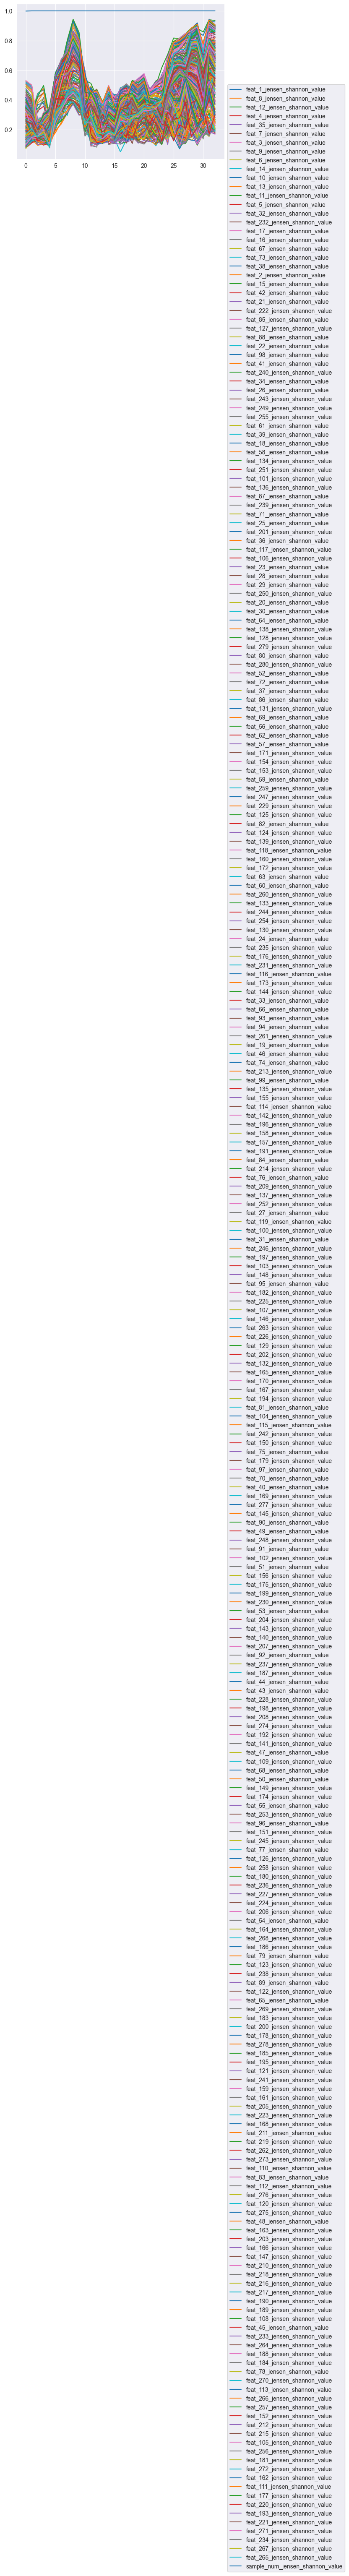

In [83]:
results_js[[col for col in results_js.columns if '_jensen_shannon_value' in col]].plot()
plt.legend(bbox_to_anchor=(1, 0.5))

In [42]:
# figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='drift')
# figure.show()

In [ ]:
# figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='distribution')
# figure.show()

### Own Jensen-Shannon

In [ ]:
# chg_points = [19000, 50000]

In [ ]:
# CT_dataset.add_changepoints(chg_points)

In [ ]:
# rad_left = 500
# rad_right = 500

In [ ]:
# max_js_score = []
# for i in range(1000, 80000, 1000):
#     chg_points = [i]
#     CT_dataset.add_changepoints(chg_points)
#     rad_left = 1000
#     rad_right = 1000
#
#     dde_exp_eq_radius = DDEffectExperiment(_dataset=CT_dataset)
#     dde_exp_eq_radius.changepoint_radius_driftscore(radius_left=rad_left, radius_right=rad_right)
#
#     mx = dde_exp_eq_radius.results_all[dde_exp_eq_radius.results_all.columns[3:-1]].iloc[0].max()
#     print(mx)
#     max_js_score.append(mx)

In [ ]:
# plt.plot(max_js_score)

In [ ]:
chg_points = [19000, 78000]
CT_dataset.add_changepoints(chg_points)
rad_left = 5000
rad_right = 5000

In [ ]:
dde_exp_eq_radius = DDEffectExperiment(_dataset=CT_dataset)
dde_exp_eq_radius.changepoint_radius_driftscore(radius_left=rad_left, radius_right=rad_right)
display(dde_exp_eq_radius.results_all)

In [ ]:
dde_exp_eq_radius.changepoint_radius_corr(radius_left=rad_left, radius_right=rad_right)

#### Change point 1

In [ ]:
len(list(itertools.product(dde_exp_eq_radius.dataset.full_df.columns, dde_exp_eq_radius.dataset.full_df.columns)))

In [ ]:
with pd.ExcelWriter(f'outputs/insects/CD_delta_vs_ro_chp_tabs.xlsx') as writer:

    for chp in CT_dataset.change_points[:1]:
        drift_threshold = 0.25
        summary_df = pd.DataFrame(columns=['feat_1', 'feat_2', 'ref_corr', 'analysis_corr', 'corr_delta', 'feat_1_cd_score', 'feat_2_cd_score', 'delta_cd_score'])

        corr_df_delta = dde_exp_eq_radius.corr_scores[chp]['corr_delta']
        corr_df_analysis = dde_exp_eq_radius.corr_scores[chp]['analysis']
        corr_df_ref = dde_exp_eq_radius.corr_scores[chp]['reference']

        cd_score_df = dde_exp_eq_radius.results_all.loc[dde_exp_eq_radius.results_all['change_point']==chp].iloc[0]

        for pair in itertools.product(dde_exp_eq_radius.dataset.full_df.columns, dde_exp_eq_radius.dataset.full_df.columns):
            feat1 = list(pair)[0]
            feat2 = list(pair)[1]

            if feat1 != feat2:
                summary_df.loc[len(summary_df.index)] = [feat1, feat2, np.abs(corr_df_ref.loc[feat1, feat2]), np.abs(corr_df_analysis.loc[feat1, feat2]), corr_df_delta.loc[feat1, feat2], cd_score_df[feat1], cd_score_df[feat2], np.abs(cd_score_df[feat1]-cd_score_df[feat2])]

        summary_df['feat_1_drift'] = np.where(summary_df['feat_1_cd_score']>drift_threshold, 1, 0)
        summary_df['feat_2_drift'] = np.where(summary_df['feat_2_cd_score']>drift_threshold, 1, 0)
        summary_df['single_feat_drift'] = np.where(summary_df['feat_1_drift'] ^ summary_df['feat_2_drift'], 1, 0)
        summary_df['feat_pair_drift'] = np.where(summary_df['feat_1_drift'] & summary_df['feat_2_drift'], 1, 0)

        summary_df.to_excel(writer, sheet_name=f'{chp}', index=False)

In [ ]:
summary_df = summary_df.sort_values(by=['feat_1_cd_score'], ascending=False)

In [ ]:
summary_df

In [ ]:
summary_df.feat_pair_drift.sum()

In [ ]:
def get_roc_auc(scores, ys):
    # false positive rate
    FPR = []
    # true positive rate
    TPR = []
    # Iterate thresholds from 0.0 to 1.0
    thresholds = np.arange(0.0, 1.01, 0.2)
    # array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

    # get number of positive and negative examples in the dataset
    P = sum(y)
    N = len(y) - P

    # iterate through all thresholds and determine fraction of true positives
    # and false positives found at this threshold
    for thresh in thresholds:
        FP=0
        TP=0
        thresh = round(thresh,2) #Limiting floats to two decimal points, or threshold 0.6 will be 0.6000000000000001 which gives FP=0
        for i in range(len(score)):
            if (score[i] >= thresh):
                if y[i] == 1:
                    TP = TP + 1
                if y[i] == 0:
                    FP = FP + 1
        FPR.append(FP/N)
        TPR.append(TP/P)

    auc = -1 * np.trapz(TPR, FPR)

    plt.plot(FPR, TPR, linestyle='--', marker='o', color='darkorange', lw = 2, label='ROC curve', clip_on=False)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve, AUC = %.2f'%auc)
    plt.legend(loc="lower right")
    plt.savefig('AUC_example.png')
    plt.show()

In [ ]:
def plot_lift_curve(y_pred, y_val, step=0.01):

    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)

    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []

    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)

   #Plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    plt.title('Lift Curve')
    plt.show()

In [ ]:
score = summary_df.ref_corr #np.array([0.8, 0.6, 0.4, 0.2])
y = summary_df.feat_pair_drift #np.array([1,0,1,0])

In [ ]:
get_roc_auc(score, y)

In [ ]:
plot_lift_curve(score, y)

### DDE calculations

In [ ]:
summary_df

In [ ]:
m = 200
k_dde = (summary_df.feat_1_drift.sum() + summary_df.feat_2_drift.sum()) / (m-1)

In [ ]:
k_dde

In [ ]:
dde_df = pd.DataFrame()

In [ ]:
dde_df['threshold'] = np.arange(0,1,0.1)

In [ ]:
dde_df['num_corr_feat_pairs'] = dde_df.threshold.map(lambda t: summary_df[summary_df['ref_corr']>=t].shape[0])
dde_df['num_drifting_feat_pairs'] = dde_df.threshold.map(lambda t: summary_df[summary_df['ref_corr']>=t].feat_pair_drift.sum())
dde_df['dde_pr'] = m/k_dde * dde_df['num_drifting_feat_pairs']/dde_df['num_corr_feat_pairs']
dde_df['dde_lift'] = dde_df['dde_pr'] / dde_df.iloc[0].dde_pr

In [ ]:
dde_df

In [ ]:
dde_df[['dde_pr', 'dde_lift']].plot()

In [ ]:
dde_fitted_coeffs = np.polyfit(dde_df.threshold, dde_df.dde_lift, 2)
dde_fitted_curve = np.poly1d(dde_fitted_coeffs)

In [ ]:
plt.plot(dde_df.threshold, dde_df.dde_lift, 'o', dde_df.threshold, dde_fitted_curve(dde_df.threshold))
plt.show()

Excel ROC AUC calculations

In [ ]:
excel_data = pd.read_excel(r'C:\Users\MarcellNemeth\Documents\BME\phd\meresek\insects\CD_delta_vs_ro_chp_tabs_insects_drift1.xlsx', sheet_name='ROC_output')

In [ ]:
excel_data

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(excel_data['real'], excel_data['check_10'])
auc = roc_auc_score(excel_data['real'], excel_data['check_10'])

# calculate AUC
plt.plot(fpr, tpr, marker='.', label='DDE method')
print('AUC: %.3f' % auc)

In [ ]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(excel_data['real'], excel_data['check_5'])
auc = roc_auc_score(excel_data['real'], excel_data['check_5'])

# calculate AUC
plt.plot(fpr, tpr, marker='.', label='DDE method')
print('AUC: %.3f' % auc)

In [ ]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(excel_data['real'], excel_data['check_3'])
auc = roc_auc_score(excel_data['real'], excel_data['check_3'])

# calculate AUC
plt.plot(fpr, tpr, marker='.', label='DDE method')
print('AUC: %.3f' % auc)

Crossvalidation of feature drift prediction

In [ ]:
import random

In [ ]:
d2_data = pd.read_excel(r'D:\Dokumentumok\BME\PhD\codes\dde\notebooks\outputs\insects\CD_delta_vs_ro_chp_tabs_insects_drift1.xlsx', sheet_name='d2')

In [ ]:
drift_gt = pd.read_excel(r'D:\Dokumentumok\BME\PhD\codes\dde\notebooks\outputs\insects\CD_delta_vs_ro_chp_tabs_insects_drift1.xlsx', sheet_name='drift_gt2')

In [ ]:
drift_gt = drift_gt.set_index('feature')

In [ ]:
all_feats = [f'feat_{f}' for f in range(1, 201)]

k_fold = 5
max_num_check_feats = 190

In [ ]:
cross_metrics = pd.DataFrame(index=pd.Index(all_feats))
cross_metrics = cross_metrics.merge(drift_gt, left_index=True, right_index=True)

for num_check_feats in range(1, max_num_check_feats+1):
    for k in range(k_fold):
        check_feats = [f'feat_{r}' for r in random.sample(range(1, 200), num_check_feats)]
        filt_data = d2_data[(d2_data['feature_1'].isin(check_feats))]

        dde_agg = filt_data.groupby('feature_2').agg({'feat2_drift_prob_local': 'sum'}).reset_index()
        dde_agg = dde_agg.rename(columns={'feat2_drift_prob_local': f'chkfts{num_check_feats}_fold{k+1}'})
        dde_agg = dde_agg.set_index('feature_2')

        cross_metrics = cross_metrics.merge(dde_agg, left_index=True, right_index=True, how='left')
        #cross_metrics = cross_metrics.fillna(cross_metrics.mean())

In [ ]:
cross_metrics

In [ ]:
cross_preds = pd.DataFrame(index=pd.Index(all_feats))
cross_preds = cross_preds.merge(drift_gt, left_index=True, right_index=True)

for num_check_feats in range(1, max_num_check_feats + 1):
    for k in range(k_fold):
        check_feats = [f'feat_{r}' for r in random.sample(range(1, 200), num_check_feats)]
        filt_data = d2_data[(d2_data['feature_1'].isin(check_feats))]

        dde_agg = filt_data.groupby('feature_2').agg({'feat_1_drift': 'mean'}).reset_index()
        dde_agg = dde_agg.rename(columns={'feat_1_drift': f'chkfts{num_check_feats}_fold{k + 1}'})
        dde_agg[f'chkfts{num_check_feats}_fold{k + 1}'] = dde_agg[f'chkfts{num_check_feats}_fold{k + 1}'].map(lambda x: 1 if x >= 0.5 else 0)

        dde_agg = dde_agg.set_index('feature_2')

        cross_preds = cross_preds.merge(dde_agg, left_index=True, right_index=True, how='left')

In [ ]:
cross_preds = cross_preds.fillna(0).rename(columns={'drift_true': 'drift_gt'}) #.drop(columns=['drift_true'])

In [ ]:
cross_preds

In [ ]:
idx = cross_preds.columns.str.split('_', expand=True)

In [ ]:
cross_preds.columns = pd.MultiIndex.from_tuples(idx)

In [ ]:
cross_preds

In [ ]:
preds_agg = pd.DataFrame(columns=cross_preds.columns[1:], index=pd.Index(pd.Series(['AUC'])))

In [ ]:
preds_agg

In [ ]:
for num_check_feats in range(1, max_num_check_feats + 1):
    for k in range(k_fold):
        # print(roc_auc_score(cross_preds['drift']['gt'], cross_preds[f'chkfts{num_check_feats}'][f'fold{k+1}']))
        auc = roc_auc_score(cross_preds['drift']['gt'], cross_preds[f'chkfts{num_check_feats}'][f'fold{k+1}'])
        preds_agg.loc['AUC', (f'chkfts{num_check_feats}', f'fold{k+1}')] = auc

In [ ]:
preds_agg.mean(level=0, axis='columns').T.plot()

### Cross validation test on Excel extract

In [ ]:
import random

In [ ]:
d2_df = pd.read_excel(r'D:\Dokumentumok\BME\PhD\codes\dde\notebooks\outputs\insects\cross_valid_test.xlsx', sheet_name='d2')
feat_1_drift_gt = d2_df.groupby('feature_1').agg({'feat_1_drift': 'max'}).rename(columns={'feat_1_drift': 'drift_gt'})

In [ ]:
measurement_df = pd.DataFrame(index=pd.Index(pd.Series(['f1_score'])))

In [ ]:
max_num_chkfts = 199
num_kfold = 20

In [ ]:
for num_chkfts in range(1, max_num_chkfts+1):
    for k in range(1, num_kfold+1):
        feats_check = [f'feat_{r}' for r in random.sample(range(1, 200), num_chkfts)]
        d2_df_filt = d2_df[(d2_df['feature_2'].isin(feats_check))]

        d2_df_filt_agg = d2_df_filt.groupby('feature_1').agg({'feat_1_drift': 'sum'})

        d2_df_filt_agg['pred'] = d2_df_filt_agg['feat_1_drift'].map(lambda x: 1 if x / num_chkfts >= 0.5 else 0)
        feat_1_drift_gt = feat_1_drift_gt.merge(d2_df_filt_agg[['pred']], left_index=True, right_index=True, how='left')

        measurement_df[f'chkfeats{num_chkfts}_fold{k}'] = f1_score(feat_1_drift_gt['drift_gt'], feat_1_drift_gt['pred'].fillna(0))

        feat_1_drift_gt = feat_1_drift_gt.drop(columns=['pred'])

In [ ]:
idx = measurement_df.columns.str.split('_', expand=True)
measurement_df.columns = pd.MultiIndex.from_tuples(idx)

In [ ]:
measurement_agg = pd.DataFrame()
measurement_agg['f1_avg'] = measurement_df.mean(level=0, axis='columns').T
measurement_agg['f1_std'] = measurement_df.std(level=0, axis='columns').T

In [ ]:
measurement_agg.plot()

In [ ]:
# plot mean with std on shaded area
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(measurement_agg['f1_avg'], color='blue')
ax.fill_between(measurement_agg.index, measurement_agg['f1_avg'] - measurement_agg['f1_std'], measurement_agg['f1_avg'] + measurement_agg['f1_std'], color='blue', alpha=0.2)
ax.set_xlabel('Number of features checked')
ax.set_ylabel('F1 score')
ax.set_title('F1 score of feature 1 drift prediction')
ax.set_ylim(0.4, 1)
ax.set_xlim(0, 200)
plt.show()

In [ ]:
feats_check = [f'feat_{r}' for r in random.sample(range(1, 200), num_chkfts)]

In [ ]:
d2_df_filt = d2_df[(d2_df['feature_2'].isin(feats_check))]

In [ ]:
d2_df_filt_agg = d2_df_filt.groupby('feature_1').agg({'feat_1_drift': 'sum'})#.sort_values('feat2_drift_prob_local', ascending=False)

In [ ]:
d2_df_filt_agg['pred'] = d2_df_filt_agg['feat_1_drift'].map(lambda x: 1 if x/num_chkfts >= 0.5 else 0)

In [ ]:
feat_1_drift_gt = feat_1_drift_gt.merge(d2_df_filt_agg[['pred']], left_index=True, right_index=True, how='left')

In [ ]:
f1_score(feat_1_drift_gt['drift_gt'], feat_1_drift_gt['pred'].fillna(0))

In [ ]:
cross_preds = pd.DataFrame(index=pd.Index(all_feats))
cross_preds = cross_preds.merge(drift_gt, left_index=True, right_index=True)

for num_check_feats in range(1, max_num_check_feats + 1):
    for k in range(k_fold):
        check_feats = [f'feat_{r}' for r in random.sample(range(1, 200), num_check_feats)]
        filt_data = d2_data[(d2_data['feature_1'].isin(check_feats))]

        dde_agg = filt_data.groupby('feature_2').agg({'feat_1_drift': 'mean'}).reset_index()
        dde_agg = dde_agg.rename(columns={'feat_1_drift': f'chkfts{num_check_feats}_fold{k + 1}'})
        dde_agg[f'chkfts{num_check_feats}_fold{k + 1}'] = dde_agg[f'chkfts{num_check_feats}_fold{k + 1}'].map(lambda x: 1 if x >= 0.5 else 0)

        dde_agg = dde_agg.set_index('feature_2')

        cross_preds = cross_preds.merge(dde_agg, left_index=True, right_index=True, how='left')

In [ ]:
cross_preds = cross_preds.fillna(0).rename(columns={'drift_true': 'drift_gt'}) #.drop(columns=['drift_true'])

In [ ]:
cross_preds

In [ ]:
idx = cross_preds.columns.str.split('_', expand=True)

In [ ]:
cross_preds.columns = pd.MultiIndex.from_tuples(idx)

In [ ]:
cross_preds

In [ ]:
preds_agg = pd.DataFrame(columns=cross_preds.columns[1:], index=pd.Index(pd.Series(['AUC'])))

In [ ]:
preds_agg

In [ ]:
for num_check_feats in range(1, max_num_check_feats + 1):
    for k in range(k_fold):
        # print(roc_auc_score(cross_preds['drift']['gt'], cross_preds[f'chkfts{num_check_feats}'][f'fold{k+1}']))
        auc = roc_auc_score(cross_preds['drift']['gt'], cross_preds[f'chkfts{num_check_feats}'][f'fold{k+1}'])
        preds_agg.loc['AUC', (f'chkfts{num_check_feats}', f'fold{k+1}')] = auc

In [ ]:
preds_agg.mean(level=0, axis='columns').T.plot()

### Cross validation test on Excel extract

In [12]:
import random

In [13]:
d2_df = pd.read_excel(r'D:\Dokumentumok\BME\PhD\codes\dde\notebooks\outputs\insects\cross_valid_test.xlsx', sheet_name='d2')
feat_1_drift_gt = d2_df.groupby('feature_1').agg({'feat_1_drift': 'max'}).rename(columns={'feat_1_drift': 'drift_gt'})

In [14]:
measurement_df = pd.DataFrame(index=pd.Index(pd.Series(['f1_score'])))

In [15]:
max_num_chkfts = 199
num_kfold = 20

In [16]:
for num_chkfts in range(1, max_num_chkfts+1):
    for k in range(1, num_kfold+1):
        feats_check = [f'feat_{r}' for r in random.sample(range(1, 200), num_chkfts)]
        d2_df_filt = d2_df[(d2_df['feature_2'].isin(feats_check))]

        d2_df_filt_agg = d2_df_filt.groupby('feature_1').agg({'feat_1_drift': 'sum'})

        d2_df_filt_agg['pred'] = d2_df_filt_agg['feat_1_drift'].map(lambda x: 1 if x / num_chkfts >= 0.5 else 0)
        feat_1_drift_gt = feat_1_drift_gt.merge(d2_df_filt_agg[['pred']], left_index=True, right_index=True, how='left')

        measurement_df[f'chkfeats{num_chkfts}_fold{k}'] = f1_score(feat_1_drift_gt['drift_gt'], feat_1_drift_gt['pred'].fillna(0))

        feat_1_drift_gt = feat_1_drift_gt.drop(columns=['pred'])

In [17]:
idx = measurement_df.columns.str.split('_', expand=True)
measurement_df.columns = pd.MultiIndex.from_tuples(idx)

In [18]:
measurement_agg = pd.DataFrame()
measurement_agg['f1_avg'] = measurement_df.mean(level=0, axis='columns').T
measurement_agg['f1_std'] = measurement_df.std(level=0, axis='columns').T

<AxesSubplot:>

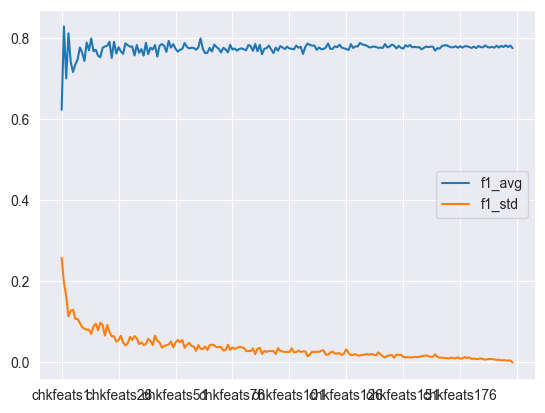

In [21]:
measurement_agg.plot()

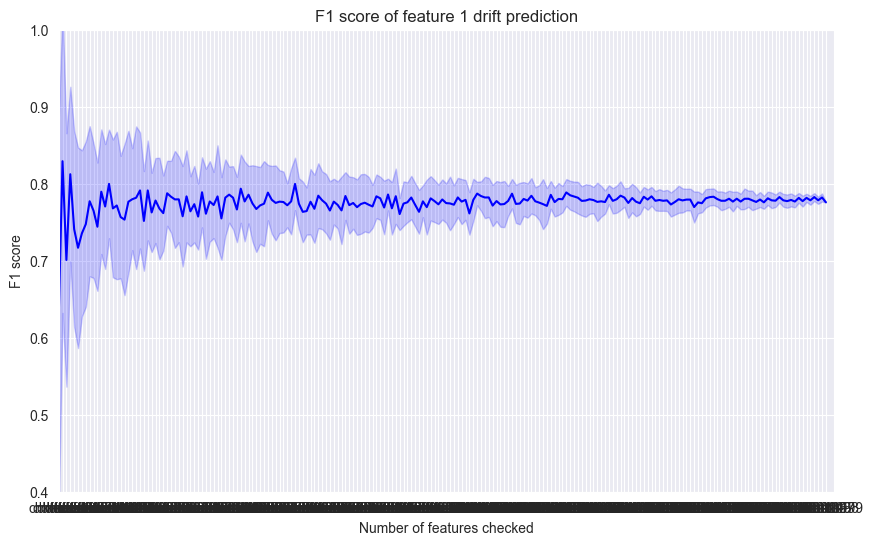

In [22]:
# plot mean with std on shaded area
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(measurement_agg['f1_avg'], color='blue')
ax.fill_between(measurement_agg.index, measurement_agg['f1_avg'] - measurement_agg['f1_std'], measurement_agg['f1_avg'] + measurement_agg['f1_std'], color='blue', alpha=0.2)
ax.set_xlabel('Number of features checked')
ax.set_ylabel('F1 score')
ax.set_title('F1 score of feature 1 drift prediction')
ax.set_ylim(0.4, 1)
ax.set_xlim(0, 200)
plt.show()

In [ ]:
feats_check = [f'feat_{r}' for r in random.sample(range(1, 200), num_chkfts)]

In [ ]:
d2_df_filt = d2_df[(d2_df['feature_2'].isin(feats_check))]

In [ ]:
d2_df_filt_agg = d2_df_filt.groupby('feature_1').agg({'feat_1_drift': 'sum'})#.sort_values('feat2_drift_prob_local', ascending=False)

In [ ]:
d2_df_filt_agg['pred'] = d2_df_filt_agg['feat_1_drift'].map(lambda x: 1 if x/num_chkfts >= 0.5 else 0)

In [ ]:
feat_1_drift_gt = feat_1_drift_gt.merge(d2_df_filt_agg[['pred']], left_index=True, right_index=True, how='left')

In [ ]:
f1_score(feat_1_drift_gt['drift_gt'], feat_1_drift_gt['pred'].fillna(0))